### Verständnis des Problems  
#### 0.1 Motivation:  

Bei der Planung energieeffizienter Gebäude ist die Berechnung der Heizlast (HL) und der Kühllast (CL) erforderlich, um die Spezifikationen der Heiz- und Kühlanlagen zu bestimmen, die für die Aufrechterhaltung komfortabler Innenraumklimabedingungen notwendig sind. Um die erforderlichen Heiz- und Kühlkapazitäten abzuschätzen, benötigen Architekten und Gebäudeplaner Informationen über die Eigenschaften des Gebäudes und der zu konditionierenden Räume (z. B. Belegung und Aktivitätsniveau). Aus diesem Grund werden wir den Einfluss von acht Eingangsvariablen untersuchen: (RC), Gesamtfläche, Wandfläche, Dachfläche, Gesamthöhe, Orientierung, Verglasungsfläche und Verteilung der Verglasungsfläche, um die Ausgangsvariablen HL und CL von Wohngebäuden zu bestimmen.


### 0.2 Verständnis der Daten  

Wir führen eine Energieanalyse mit 12 verschiedenen Gebäudeformen durch, die in Ecotect simuliert wurden. Die Gebäude unterscheiden sich in Bezug auf die Verglasungsfläche, die Verteilung der Verglasungsfläche und die Orientierung sowie weitere Parameter. Wir simulieren verschiedene Einstellungen basierend auf den genannten Merkmalen, um 768 Gebäudeformen zu erhalten. Der Datensatz umfasst 768 Stichproben und 8 Merkmale, mit dem Ziel, zwei kontinuierliche Zielgrößen vorherzusagen. Alternativ kann der Datensatz auch als ein Multi-Klassen-Klassifikationsproblem verwendet werden, wenn die Zielwerte auf die nächste ganze Zahl gerundet werden.

### 0.3 Datenbeschreibung  

Der Datensatz enthält acht Attribute (oder Merkmale) und zwei Zielgrößen (oder Ergebnisse). Ziel ist es, anhand der acht Merkmale die beiden Zielgrößen vorherzusagen.  

#### Merkmale:  
- **RelativeCompactness** (Relative Kompaktheit)  
- **SurfaceArea** (Oberfläche)  
- **WallArea** (Wandfläche)  
- **RoofArea** (Dachfläche)  
- **OverallHeight** (Gesamthöhe)  
- **Orientation** (Ausrichtung)  
- **GlazingArea** (Verglasungsfläche)  
- **GlazingAreaDistribution** (Verteilung der Verglasungsfläche)  

#### Zielgrößen:  
- **HeatingLoad** (Heizlast)  
- **CoolingLoad** (Kühllast)  

1. Importieren von Bibliotheken

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
from scipy.stats import randint as sp_randint
"""from catboost import CatBoostRegressor"""
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense
from keras.models import Sequential
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

2. Importieren des Datensatzes

In [4]:
data = pd.read_csv('/content/energy_efficiency_data.csv')

3. Datenexploration

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


<Axes: >

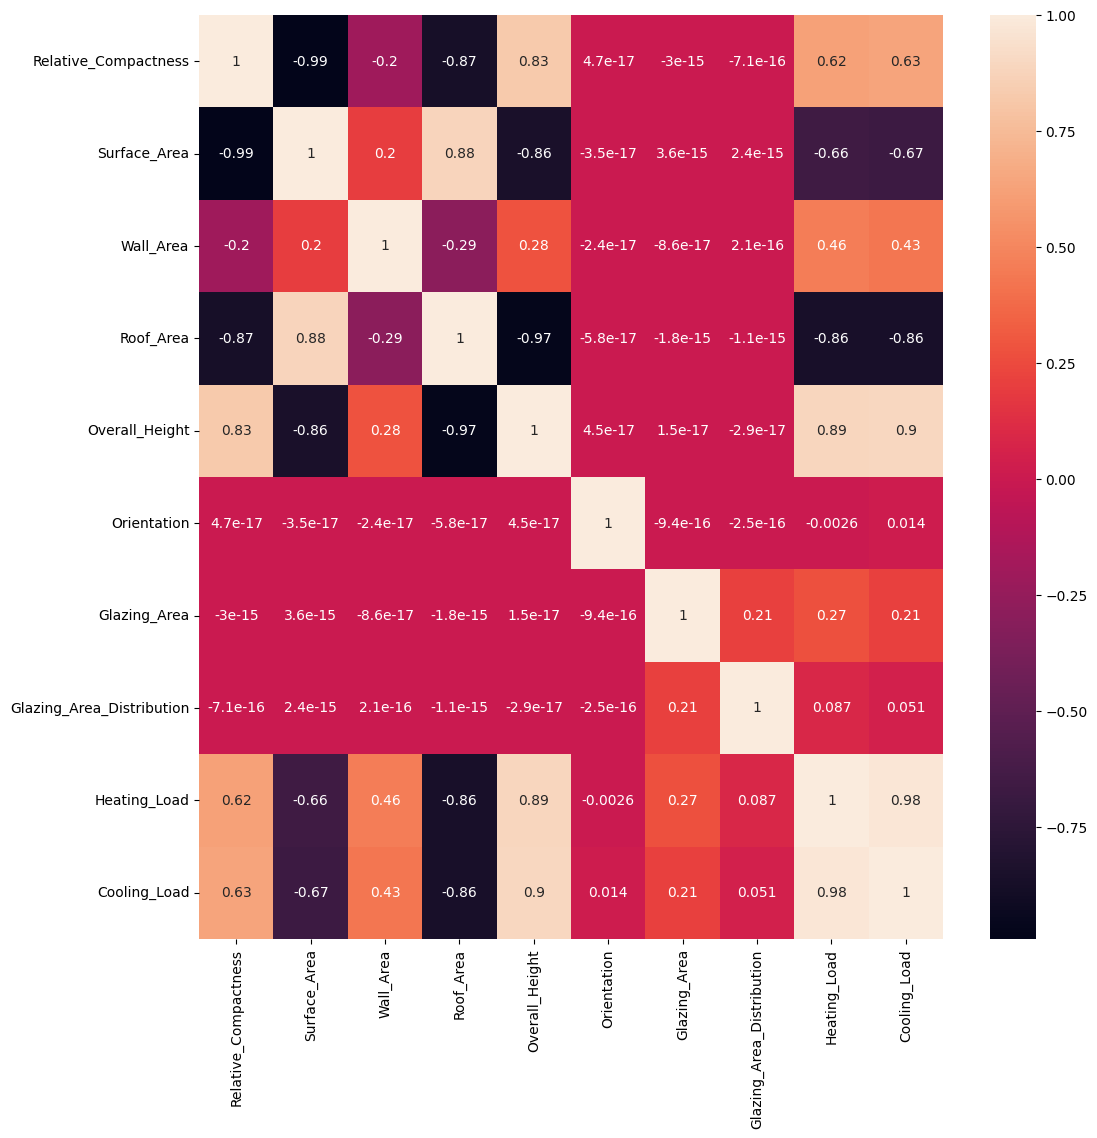

In [6]:
# Preview correlation
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(),annot=True)

- Histogramm der Merkmale

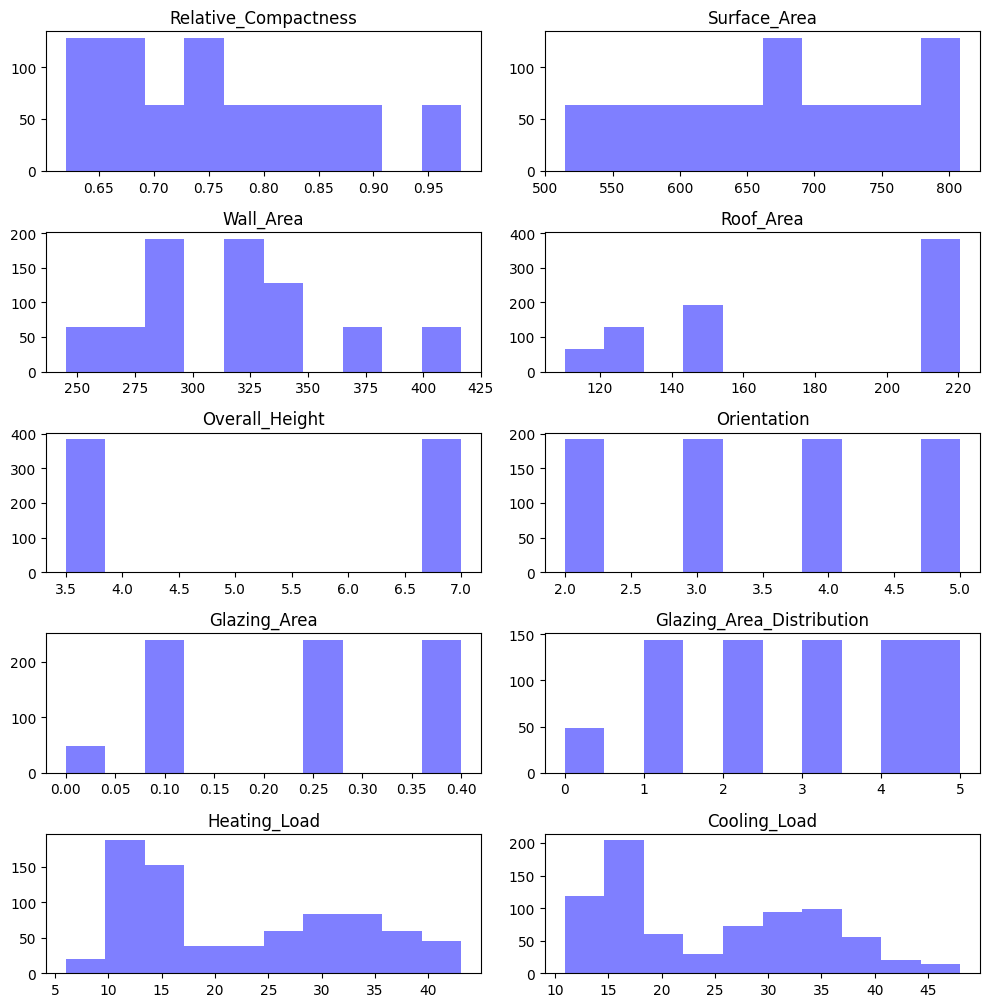

In [7]:
num_list = list(data.columns)

fig = plt.figure(figsize=(10,30))

for i in range(len(num_list)):
    plt.subplot(15,2,i+1)
    plt.title(num_list[i])
    plt.hist(data[num_list[i]],color='blue',alpha=0.5)

plt.tight_layout()

- Pairplot der Merkmale

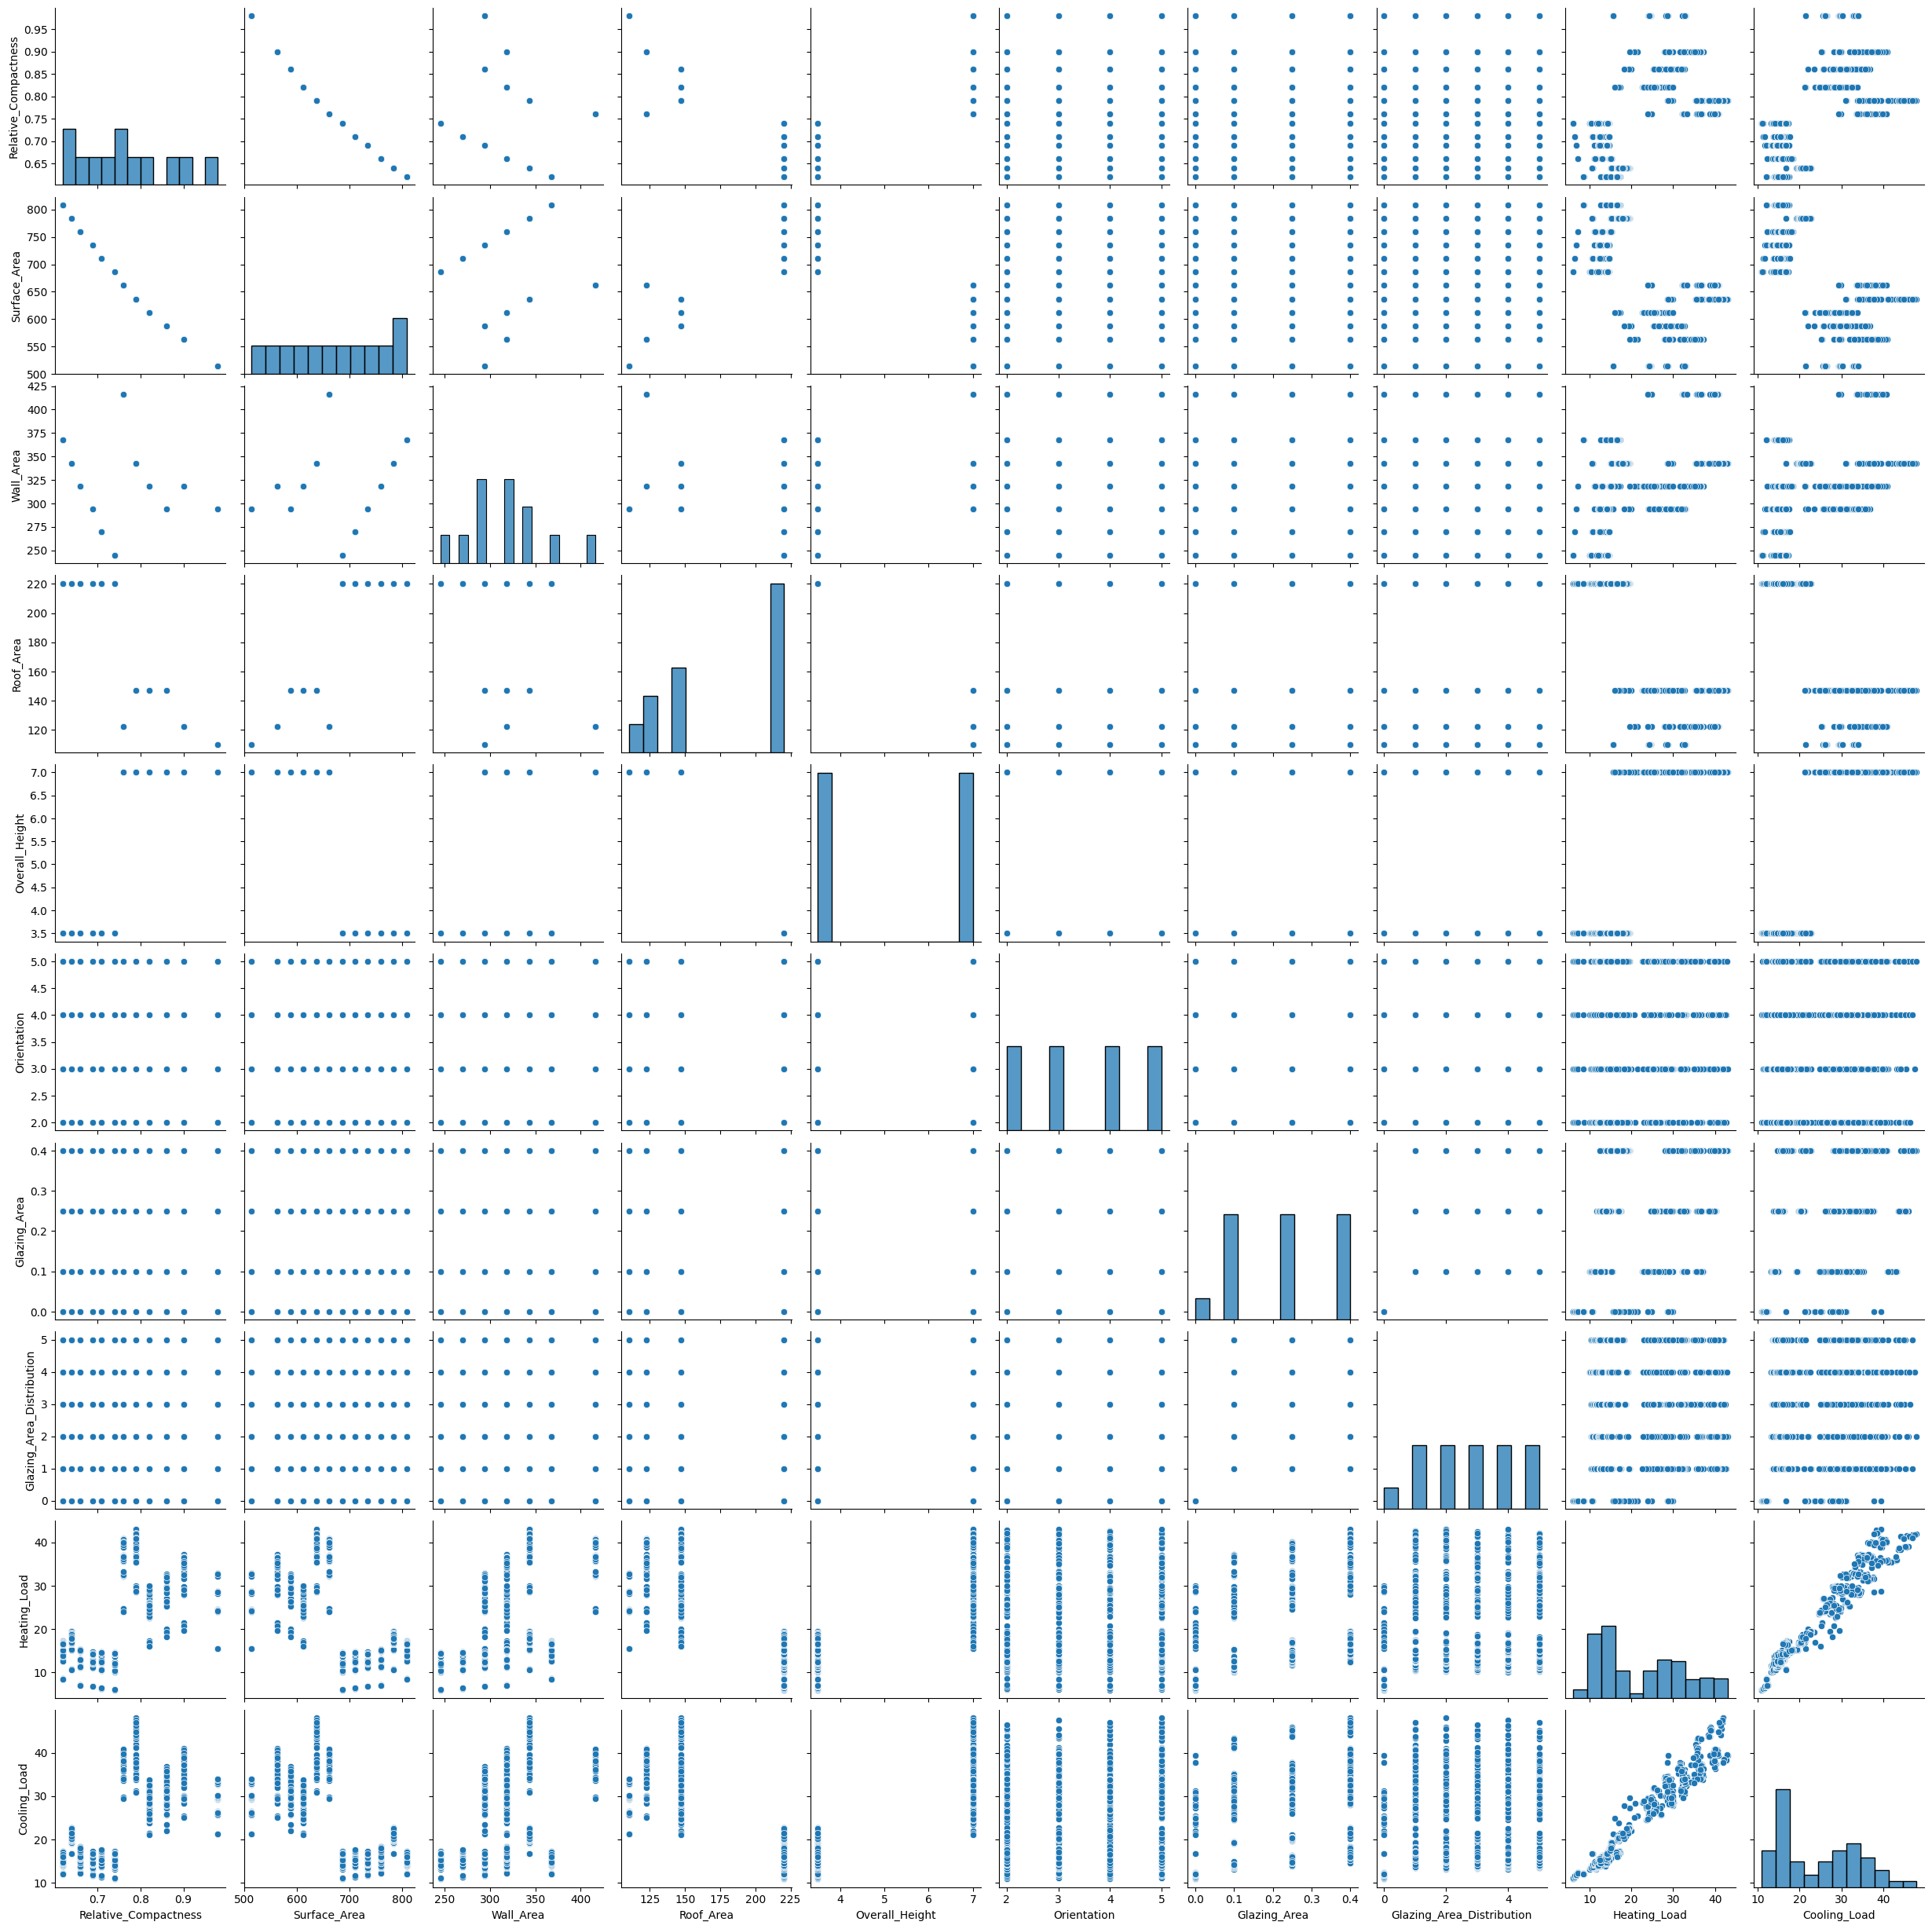

In [8]:
sns.pairplot(data)

- Darstellung der Heiz- und Kühllast

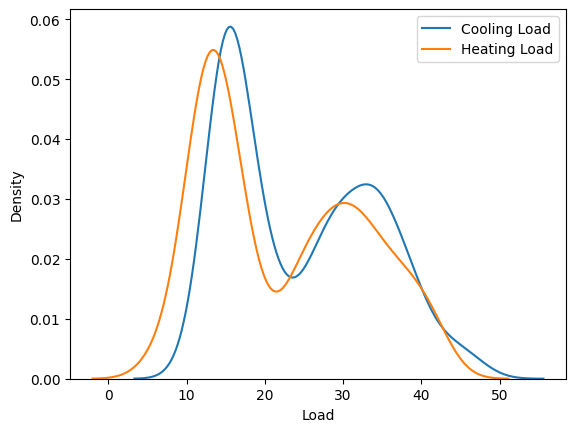

In [9]:
sns.distplot(data['Cooling_Load'],hist=False)
sns.distplot(data['Heating_Load'],hist=False)
plt.legend(['Cooling Load','Heating Load'])
plt.xlabel('Load')
plt.show()

4. Datenvorverarbeitung

In [10]:
df = data.copy()
#df_2 = data.copy()

In [11]:
X = df[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
       'Overall_Height', 'Orientation', 'Glazing_Area','Glazing_Area_Distribution']]
y_h = df[['Heating_Load']]
y_c = df[['Cooling_Load']]

- 4.1 Normalisierung

In [12]:
# define standard scaler
mmx_scaler = MinMaxScaler()
stand_scalar = StandardScaler()
# transform data
X_normalized = mmx_scaler.fit_transform(X)
X_standarized = stand_scalar.fit_transform(X)

5. Modellanpassung

- 5.1 Aufteilen in Trainings- und Testdatensatz

In [13]:
X_train, X_test, yh_train, yh_test, yc_train, yc_test = train_test_split(X_normalized,y_h,y_c,
                                                                         test_size=0.33, random_state = 42)

In [14]:
Acc = pd.DataFrame(index=None,
                   columns=['model','train_Heating','test_Heating','train_Cooling','test_Cooling'])

In [15]:
regressors = [['SVR',SVR()],
              ['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['KNeighborsRegressor', KNeighborsRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()],
              ['LinearRegression',LinearRegression()]]


In [19]:
for mod in regressors:
    name = mod[0]
    model = mod[1]

    model.fit(X_train,yh_train)
    actr1 = r2_score(yh_train, model.predict(X_train))
    acte1 = r2_score(yh_test, model.predict(X_test))

    model.fit(X_train,yc_train)
    actr2 = r2_score(yc_train, model.predict(X_train))
    acte2 = r2_score(yc_test, model.predict(X_test))

    Acc = Acc._append(pd.Series({'model':name, 'train_Heating':actr1,'test_Heating':acte1,'train_Cooling':actr2,'test_Cooling':acte2}),ignore_index=True)



Acc.sort_values(by='test_Cooling')


,model,train_Heating,test_Heating,train_Cooling,test_Cooling
4,MLPRegressor,0.875363,0.868849,0.830556,0.829133
0,SVR,0.925069,0.918868,0.891179,0.883210
7,LinearRegression,0.915838,0.915594,0.886005,0.889554
2,KNeighborsRegressor,0.945723,0.915916,0.928036,0.900107
5,AdaBoostRegressor,0.969510,0.964229,0.938120,0.935833
1,DecisionTreeRegressor,1.000000,0.996480,1.000000,0.963119
3,RandomForestRegressor,0.999616,0.997614,0.994994,0.972567
6,GradientBoostingRegressor,0.998356,0.997671,0.981346,0.977536
